preprocess.py (전체 흐름)

load & reorient & HU

resample 3D

skull strip & optional center crop

window & normalize (loop over experiments)

pad_or_crop_safe to shape.volume

for each axis, method → generate projection, apply same window/normalize, pad2d to shape.slice

torch.save with keys

In [ ]:
# 로컬: %cd C:\Users\401-09\Preprocessing

In [ ]:
# 필요시 폴더 삭제
!rm -r 경로명

In [9]:
%cd /content

/content


In [10]:
# GitHub에서 프로젝트 클론
#    → <YOUR_REPO_URL> 부분을 실제 리포지토리 URL로 바꿔주세요.
!git clone https://github.com/MANDUnoko/Preprocessing
%cd Preprocessing

Cloning into 'Preprocessing'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 279 (delta 5), reused 6 (delta 1), pack-reused 257 (from 2)
Receiving objects: 100% (279/279), 572.05 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/content/Preprocessing


In [54]:
!git fetch origin main

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 1.07 KiB | 1.07 MiB/s, done.
From https://github.com/MANDUnoko/Preprocessing
 * branch            main       -> FETCH_HEAD
   4b01e7b..a523d12  main       -> origin/main


In [55]:
!git checkout origin/main -- /content/Preprocessing/scripts/preprocess.py

In [56]:
!git checkout origin/main -- /content/Preprocessing/configs/preprocessing.yaml

In [11]:
# Google Drive 마운트 (필요한 경우)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!sed -n '1,20p' configs/preprocessing.yaml

data_dir: "data"

spacings:
  original: [5.0, 0.4121, 0.4121]
  target:   [1.0, 1.0, 1.0]

window:
  level: 40
  width: 80
  experiments:
    - [0, 80]
    - [0, 200]

shape:
  volume: [140, 250, 250]
  slice:  [250, 250]

projections:
  axes: [0,1,2]   # Z, Y, X
  methods: [mip, aip, mid]


In [29]:
import os
os.environ["DATA_DIR"] = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data"


=== Processing case 049 ===


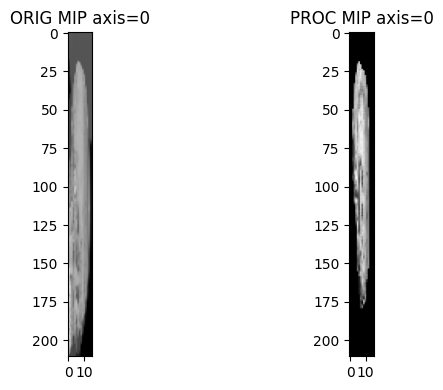

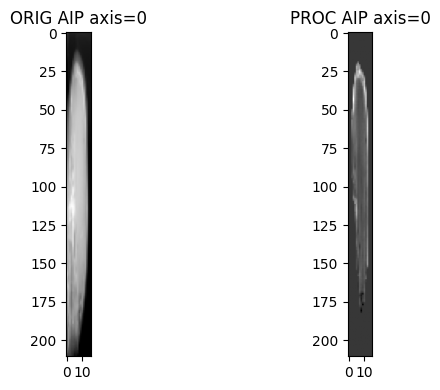

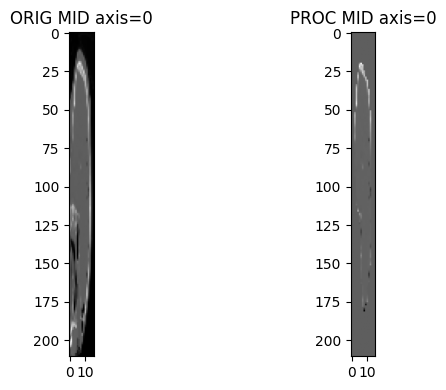

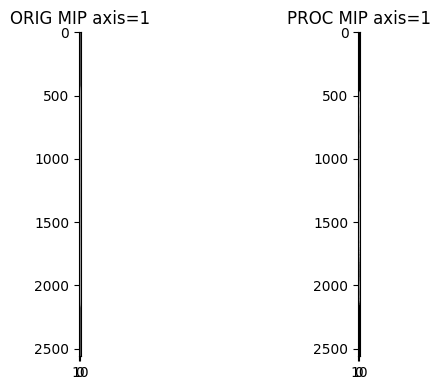

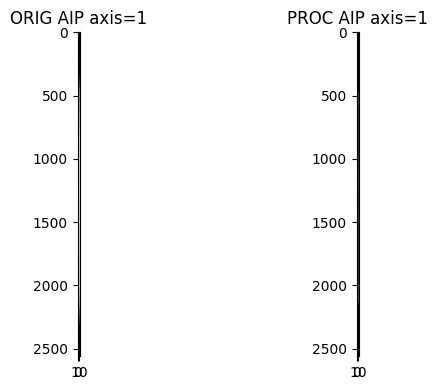

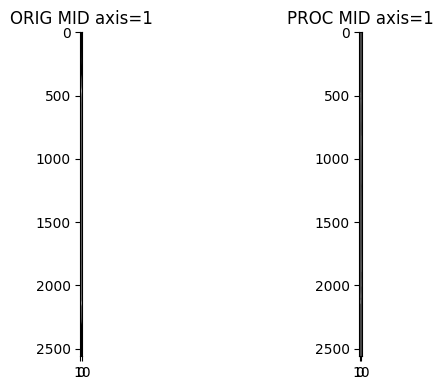

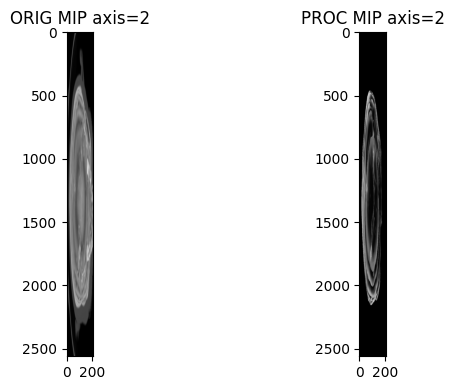

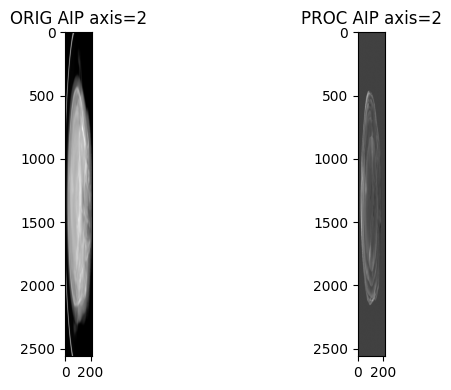

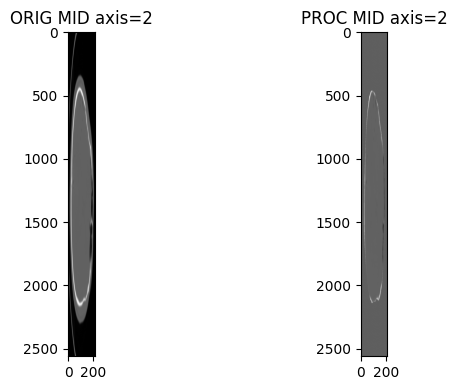

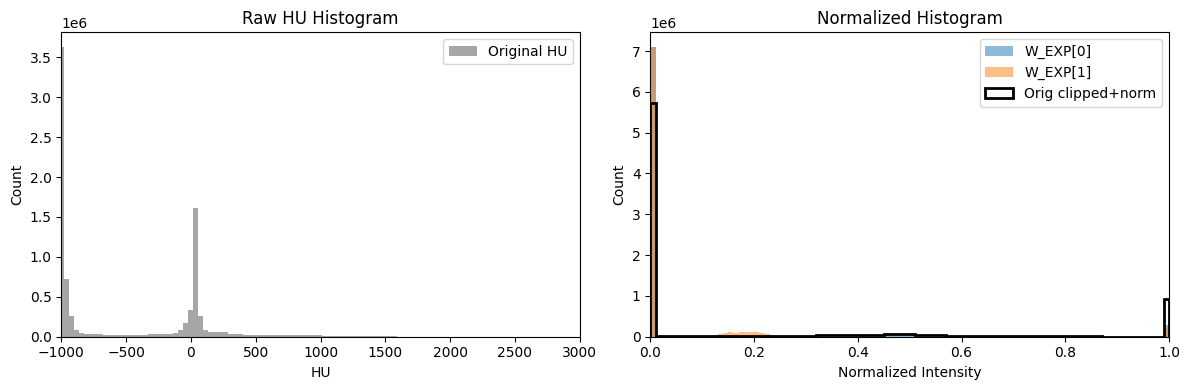

[✔] Saved: 049


<Figure size 640x480 with 0 Axes>

In [58]:
%run scripts/preprocess.py

In [59]:
# =========================================
# 저장된 .pt 파일 불러와 수치 검증
# =========================================
from pathlib import Path
import torch
import numpy as np

# case_id와 processed 폴더 경로
case_id = "049"
processed_dir = Path("/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/processed")     # preprocess.py 에서 OUT_DIR 지정한 곳
pt_path = processed_dir / f"{case_id}.pt"

# 1) .pt 로드
data = torch.load(pt_path)

# 2) 이미지·마스크 꺼내기 (3D: [1, D, H, W] → [D, H, W])
image = data["volume"][0].numpy()    # scripts에서는 "volume" key 로 저장했으면 이걸로
mask  = data["mask"][0].numpy()

# 3) 기본 통계 출력
print("\n[Image Stats]")
print(f"  Mean:  {image.mean():.4f}")
print(f"  Std:   {image.std():.4f}")
print(f"  Min/Max: {image.min():.2f} / {image.max():.2f}")
print(f"  Shape: {image.shape}")
print(f"  Spacing: {data['meta']['spacing']}")

# 4) SNR / CNR 계산 (병변 픽셀 vs 배경 픽셀)
lesion     = image[mask == 1]
background = image[(mask == 0) & (image > 0)]  # skull strip 후 배경(0) 제외

if lesion.size > 0 and background.size > 0:
    snr = lesion.mean() / (lesion.std() + 1e-5)
    cnr = abs(lesion.mean() - background.mean()) / (background.std() + 1e-5)
    print("\n[Signal Quality]")
    print(f"  SNR: {snr:.4f}")
    print(f"  CNR: {cnr:.4f}")
else:
    print("\n[Signal Quality] 병변 또는 배경 데이터가 충분치 않음")


[Image Stats]
  Mean:  0.0191
  Std:   0.1080
  Min/Max: 0.00 / 1.00
  Shape: (140, 250, 250)
  Spacing: (1.0, 1.0, 1.0)

[Signal Quality]
  SNR: 5.1977
  CNR: 0.5656
